## # Exploratory Data Analysis: LSOA Boundaries

-This notebook performs a clean, reproducible EDA on Lower Layer Super Output Areas (LSOAs) with a focus on the NHS South West region, integrating spatial boundaries and IMD deprivation.


In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx
import fiona
import os
import warnings

sns.set(style='whitegrid')
warnings.filterwarnings("ignore")

In [8]:
# ## 1. Load and Inspect LSOA Boundary Shapefile

LSOA_PATH = "../../data/raw/lsoa_shapefile/Lower_layer_Super_Output_Areas_(December_2021)_Boundaries_EW_BFC_(V10).shp"


assert os.path.exists(LSOA_PATH), f"Missing LSOA shapefile at {LSOA_PATH}"
print(f"File exists: {LSOA_PATH}")

# Inspect columns and CRS
with fiona.open(LSOA_PATH) as src:
    print("Columns:", src.schema['properties'].keys())
    print("CRS:", src.crs)

lsoa_gdf = gpd.read_file(LSOA_PATH)
print(f"Loaded {lsoa_gdf.shape[0]:,} LSOA records")
print(lsoa_gdf.head())


File exists: ../../data/raw/lsoa_shapefile/Lower_layer_Super_Output_Areas_(December_2021)_Boundaries_EW_BFC_(V10).shp
Columns: dict_keys(['FID', 'LSOA21CD', 'LSOA21NM', 'LSOA21NMW', 'BNG_E', 'BNG_N', 'LAT', 'LONG', 'Shape__Are', 'Shape__Len', 'GlobalID'])
CRS: EPSG:27700
Loaded 35,672 LSOA records
   FID   LSOA21CD                   LSOA21NM LSOA21NMW   BNG_E   BNG_N  \
0    1  E01000001        City of London 001A      None  532123  181632   
1    2  E01000002        City of London 001B      None  532480  181715   
2    3  E01000003        City of London 001C      None  532239  182033   
3    4  E01000005        City of London 001E      None  533581  181283   
4    5  E01000006  Barking and Dagenham 016A      None  544994  184274   

        LAT      LONG     Shape__Are   Shape__Len  \
0  51.51817 -0.097150  129865.314476  2635.767993   
1  51.51883 -0.091970  228419.782242  2707.816821   
2  51.52174 -0.095330   59054.204697  1224.573160   
3  51.51469 -0.076280  189577.709503  2275.8

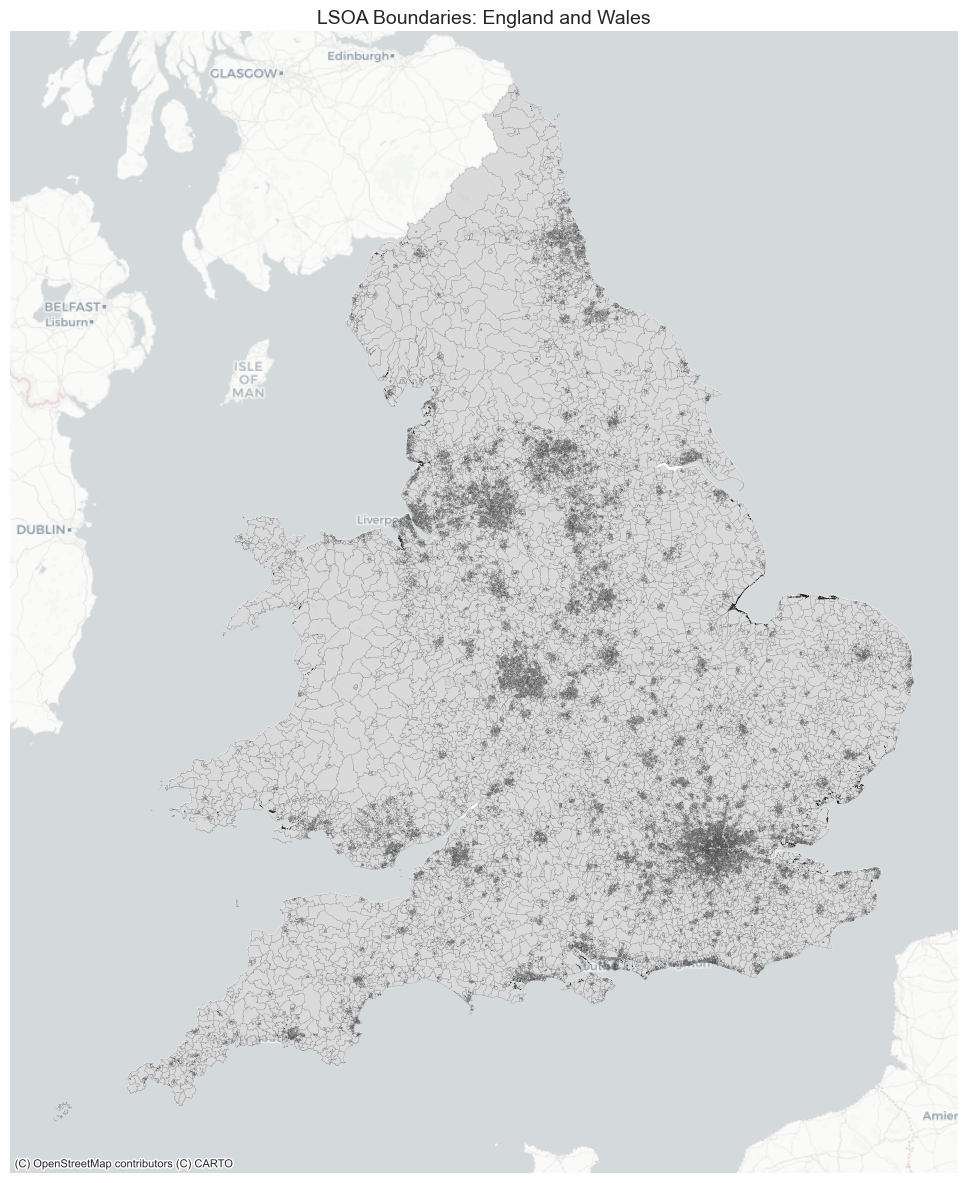

In [9]:
# ## 2. Visualise All LSOAs (England & Wales)

lsoa_gdf_web = lsoa_gdf.to_crs(epsg=3857)
fig, ax = plt.subplots(figsize=(10, 12))
lsoa_gdf_web.plot(ax=ax, edgecolor="black", facecolor="lightgrey", linewidth=0.08, alpha=0.8)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=lsoa_gdf_web.crs)
ax.set_title("LSOA Boundaries: England and Wales", fontsize=14)
ax.axis("off")
plt.tight_layout()
plt.show()

In [13]:
# --- Load NHS England Regions Shapefile and Filter South West ---

# Set correct path (update if your folder structure is different)
NHS_REGIONS_PATH = "../../data/raw/NHS_England_Regions_December_2023/NHSER_DEC_2023_EN_BFC.shp"


# Diagnostics for debugging file not found errors
print(f"Current directory: {os.getcwd()}")
print(f"Checking for NHS England regions shapefile at: {NHS_REGIONS_PATH}")
assert os.path.exists(NHS_REGIONS_PATH), f"Missing NHS shapefile at {NHS_REGIONS_PATH}"

# Load the shapefile
nhs_gdf = gpd.read_file(NHS_REGIONS_PATH)
print(f"Loaded NHS England regions shapefile with {len(nhs_gdf)} records.")
print("Columns:", nhs_gdf.columns.tolist())

# Check available region names
print("\nUnique NHS region names found:")
print(nhs_gdf[['NHSER23CD', 'NHSER23NM']].drop_duplicates())

# Filter for the South West region (careful with spelling/casing)
sw_region = nhs_gdf[nhs_gdf["NHSER23NM"].str.strip() == "South West"]
print(f"\nSouth West NHS region geometry loaded: {len(sw_region)} region(s)")
sw_region.head()


Current directory: /Users/rosstaylor/Downloads/Research Project/Code Folder/Research Project - Geospatial Health Demand/notebooks/data
Checking for NHS England regions shapefile at: ../../data/raw/NHS_England_Regions_December_2023/NHSER_DEC_2023_EN_BFC.shp
Loaded NHS England regions shapefile with 7 records.
Columns: ['NHSER23CD', 'NHSER23NM', 'BNG_E', 'BNG_N', 'LONG', 'LAT', 'GlobalID', 'geometry']

Unique NHS region names found:
   NHSER23CD                 NHSER23NM
0  E40000003                    London
1  E40000005                South East
2  E40000006                South West
3  E40000007           East of England
4  E40000010                North West
5  E40000011                  Midlands
6  E40000012  North East and Yorkshire

South West NHS region geometry loaded: 1 region(s)


,NHSER23CD,NHSER23NM,BNG_E,BNG_N,LONG,LAT,GlobalID,geometry
2,E40000006,South West,285013,102567,-3.63346,50.8112,ae070703-4bf8-464b-afd7-d2ad571fa3fc,"MULTIPOLYGON (((83962.84 5401.15, 83970.68 540..."


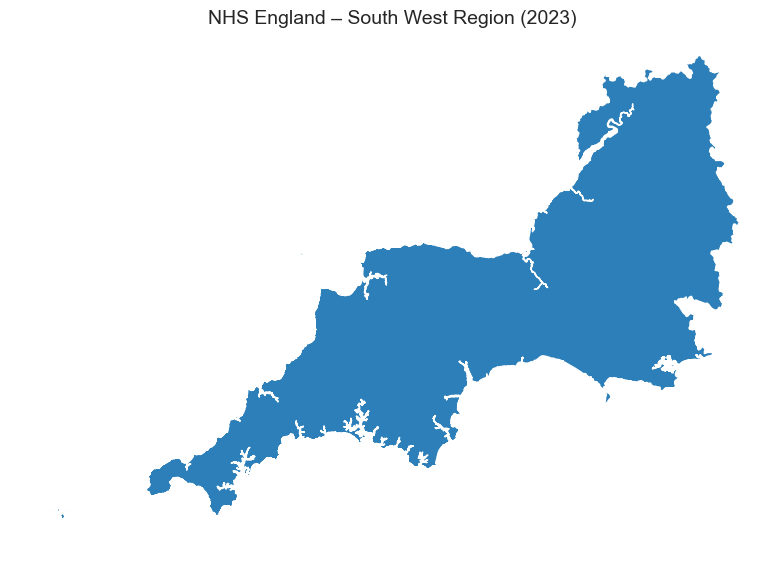

In [14]:
# Plot South West region
fig, ax = plt.subplots(figsize=(8, 10))
sw_region.plot(ax=ax, color="#2c7fb8", edgecolor="white", linewidth=1)
ax.set_title("NHS England – South West Region (2023)", fontsize=14)
ax.axis("off")
plt.tight_layout()
plt.show()



South West NHS region geometry loaded: 1 region(s)

LSOAs in NHS South West region: 3476


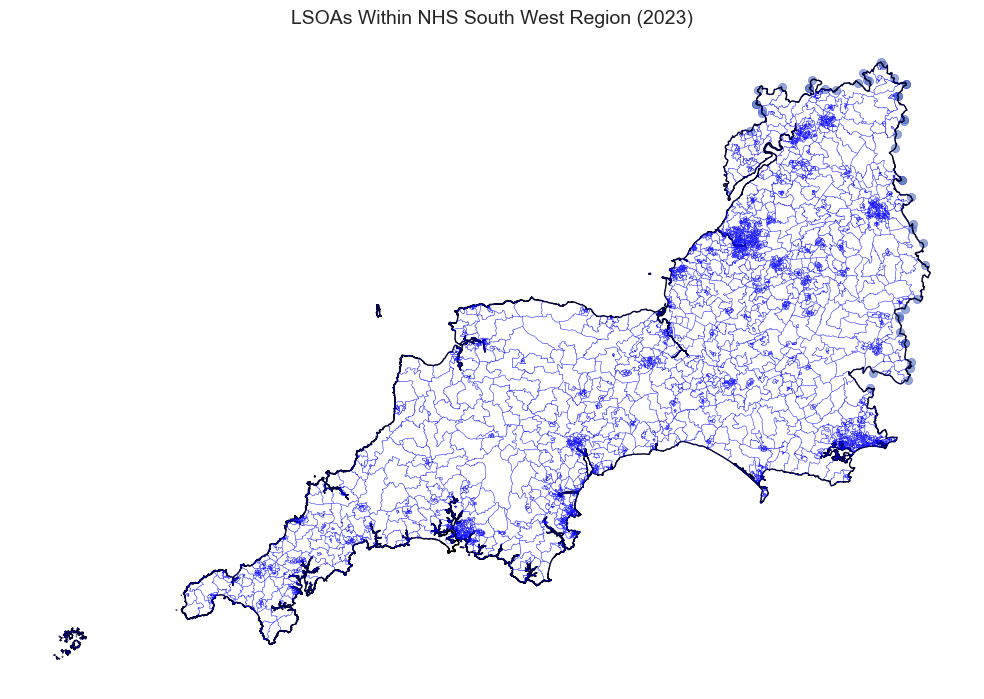

In [15]:
# --- Filter for South West NHS Region, Align CRS, and Clip LSOAs ---

# 1. Filter South West region from NHS regions GeoDataFrame
sw_region = nhs_gdf[nhs_gdf["NHSER23NM"] == "South West"]
print(f"\nSouth West NHS region geometry loaded: {len(sw_region)} region(s)")

# 2. Ensure both layers use the same CRS for spatial ops
if lsoa_gdf.crs != sw_region.crs:
    lsoa_gdf = lsoa_gdf.to_crs(sw_region.crs)
    print("📐 Reprojected LSOA CRS to match NHS region.")

# 3. Spatially clip LSOAs to South West boundary
lsoa_sw = gpd.clip(lsoa_gdf, sw_region)
print(f"\nLSOAs in NHS South West region: {len(lsoa_sw)}")

# 4. Visualise result
fig, ax = plt.subplots(figsize=(10, 12))
sw_region.boundary.plot(ax=ax, edgecolor="black", linewidth=1)
lsoa_sw.boundary.plot(ax=ax, edgecolor="blue", linewidth=0.3, alpha=0.6)
ax.set_title("LSOAs Within NHS South West Region (2023)", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()
